# OCR Pipeline
We will be implementing the full pipeline by making use of the custom object detector trained (using YOLOv5) and Optical Character Recognition (OCR), to extract bus number from bus panel.

## Setup
All libraries used should be added here.

In [3]:
# import libraries
import torch
import numpy as np
import cv2
import imutils
from PIL import Image
import pytesseract
from gtts import gTTS
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# before we start (if not done)
#!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # install dependencies

In [3]:
# clone repo to current directory (if not done)
#!git clone https://github.com/ultralytics/yolov5.git

Recall that in the previous section, the trained model weights (`best.pt`) was saved to the [google drive](https://drive.google.com/file/d/1-NJn1OtNBtYMwKEpygaagJSTVVUxFSGV/view?usp=sharing). We'll need to download the trained model weights first and save to `./yolov5` folder. 

*Note: Proceed only when the trained model weights are saved to `./yolov5` folder.*

## Find bounding box of the bus panel
Inference with YOLOv5 and PyTorch Hub.

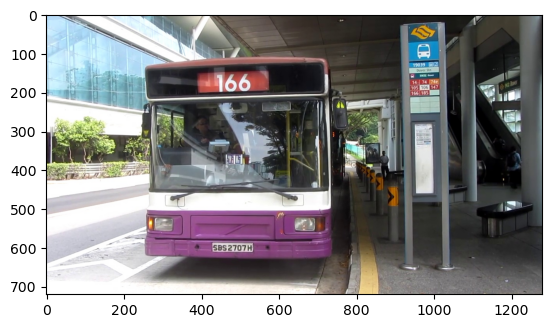

In [4]:
# select a test image
test_image = '/home/shubhamp/Downloads/Detection_of_BusNo_in_BusPanel/data/test/images/bus_video1_264.jpg'

# opening the File
img = Image.open(test_image)
# convert to numpy array
img = np.array(img)
plt.imshow(img);

In [5]:
# model
model = torch.hub.load('yolov5', 'custom', path='best', source='local') 

# inference
results = model(img)

# results
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

YOLOv5  bbe6964 torch 1.9.0+cu102 CPU

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPs
Adding AutoShape... 
image 1/1: 720x1280 1 bus panel
Speed: 2.0ms pre-process, 188.0ms inference, 1.0ms NMS per image at shape (1, 3, 384, 640)


In [6]:
bounding_box = results.pandas().xyxy[0]  # img predictions (pandas)

In [7]:
display(bounding_box)

,xmin,ymin,xmax,ymax,confidence,class,name
0,388.715393,143.01062,578.040955,203.381226,0.942663,0,bus panel


### Create Region of Interest (ROI)

In [8]:
# xmin
x_min = int(bounding_box['xmin'][0])

# xmax
x_max = int(bounding_box['xmax'][0])

# ymin
y_min = int(bounding_box['ymin'][0])

# ymax
y_max = int(bounding_box['ymax'][0])

# use numpy slicing to crop the region of interest
roi = img[y_min:y_max,x_min:x_max] 

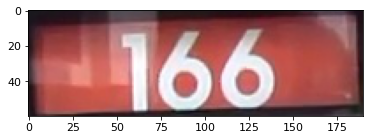

In [9]:
# plot the region of interest
plt.imshow(roi);

### Preprocess

In [10]:
# define a helper function to show image
def show_pic(img):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

In [11]:
# define helper functions to preprocess the ROI
# get grayscale image
def get_grayscale(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

# thresholding
def thresholding(image):
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return thresh


In [12]:
gray = get_grayscale(roi)
thresh = thresholding(gray)

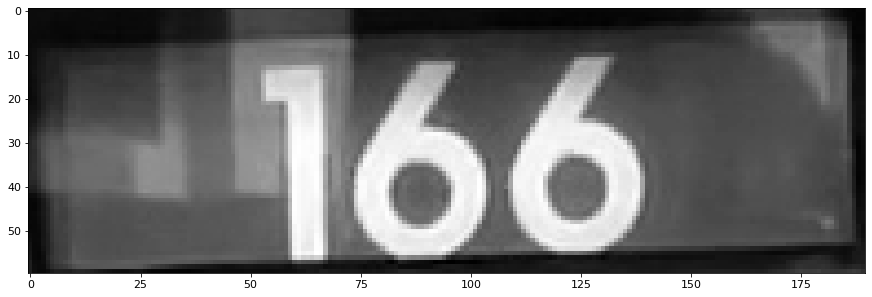

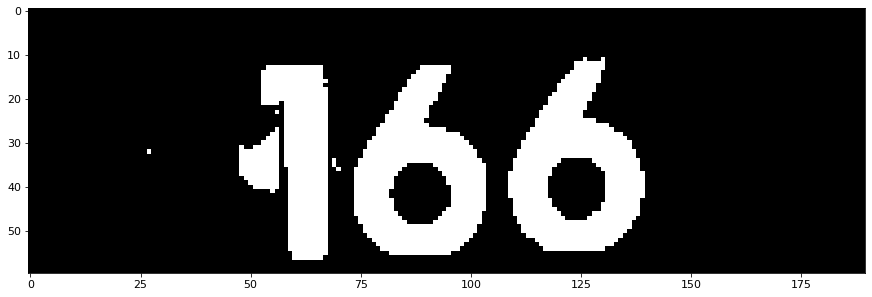

In [13]:
show_pic(gray)
show_pic(thresh)

## OCR'ing Digits with Tesseract and OpenCV

In [14]:
# path may be different for individuals
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'  

Bus Number: 166


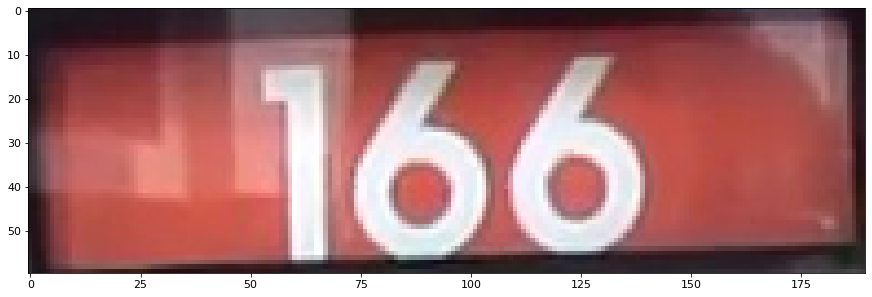

In [15]:
# recognise only digits by changing the config to the following
custom_config = r'--oem 3 --psm 6 outputbase digits'

# OCR the input image using Tesseract
text = pytesseract.image_to_string(thresh, config=custom_config)

# check if output is a number
try:
    number = int(text)
except ValueError:
    print("Could not read the bus number.")
else:
    # output the number if detected
    print(f'Bus Number: {int(text)}')
    
show_pic(roi)